##  Teil 1: Datenvorbereitung & Farbraum-Analyse

**Ziel:** 
- Daten laden und verstehen
- RGB → HSV Konversion durchführen
- Identifizieren welcher Kanal (H, S, V) am besten Tumorgewebe zeigt
- Schwellenwert-Maske erstellen

**Warum HSV?**  
RGB mischt Farbinformation mit Helligkeit. HSV trennt:
- **Hue** (Farbton): Welche Farbe (0-360°)
- **Saturation** (Sättigung): Wie intensiv die Farbe (0-1)
- **Value** (Helligkeit): Wie hell/dunkel (0-1)

→ Wichtig für H&E-Färbung: **Saturation** isoliert stark gefärbte Strukturen!

---

## Imports & Setup

In [ ]:
# import
# pyright: ignore[reportMissingImports]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from skimage import io, color, filters
from skimage.util import img_as_float, img_as_ubyte
from PIL import Image

# File handling
import os
from pathlib import Path
import glob

# Progress bar
from tqdm import tqdm

# Plotting Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Für bessere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Alle Libraries erfolgreich importiert!")

Alle Libraries erfolgreich importiert!


# Daten laden & Überblick verschaffen

In [48]:
# Pfade
DATA_DIR = Path('../data/raw')
CSV_PATH = DATA_DIR / 'data_histotexture.csv'
RESULTS_DIR = Path('../results/figures')

# CSV laden
df = pd.read_csv(CSV_PATH)

print(f"Dataset geladen: {len(df)} Bilder")
print(f"Erste 5 Zeilen:")
df.head()

Dataset geladen: 100 Bilder
Erste 5 Zeilen:


file_path  label_is_malignant  \
0  prepared_patches_p4\texture_patch_0053.png                   1   
1  prepared_patches_p4\texture_patch_0087.png                   1   
2  prepared_patches_p4\texture_patch_0047.png                   0   
3  prepared_patches_p4\texture_patch_0080.png                   1   
4  prepared_patches_p4\texture_patch_0024.png                   0   

   stain_quality  patch_size_px  
0            1.0            512  
1            2.0            512  
2            4.0            512  
3            NaN            512  
4            NaN            512

In [49]:
# Dataset-Info
print("Dataset-Informationen:")
print(f"Spalten: {df.columns.tolist()}")
print(f"\nShape: {df.shape}")
print(f"\n Label-Verteilung:")
print(df['label_is_malignant'].value_counts())
print(f"\n Perfekt balanciert: {df['label_is_malignant'].value_counts()[0]} Normal vs {df['label_is_malignant'].value_counts()[1]} Tumor")
print(f"Beschreibung: {df.describe()}")

# Gucken wie viele ungültige Werte da drin sind
print(f"Anzahl nicht definierte Zahlen bei Stain_quality: {df["stain_quality"].isna().sum()}")

Dataset-Informationen:
Spalten: ['file_path', 'label_is_malignant', 'stain_quality', 'patch_size_px']

Shape: (100, 4)

 Label-Verteilung:
label_is_malignant
1    50
0    50
Name: count, dtype: int64

 Perfekt balanciert: 50 Normal vs 50 Tumor
Beschreibung:        label_is_malignant  stain_quality  patch_size_px
count          100.000000      75.000000          100.0
mean             0.500000       2.626667          512.0
std              0.502519       1.136297            0.0
min              0.000000       1.000000          512.0
25%              0.000000       2.000000          512.0
50%              0.500000       3.000000          512.0
75%              1.000000       4.000000          512.0
max              1.000000       4.000000          512.0
Anzahl nicht definierte Zahlen bei Stain_quality: 25


In [50]:
# Verfügbare Bilder finden
available_images = glob.glob(str(DATA_DIR / 'prepared_patches_p4/texture_patch_*.png'))
print(f"Gefundene Bilder: {len(available_images)}")
print(f"\nErste 5 Bilder:")
for img in available_images[:5]:
    print(f"  - {Path(img).name}")

Gefundene Bilder: 100

Erste 5 Bilder:
  - texture_patch_0079.png
  - texture_patch_0051.png
  - texture_patch_0045.png
  - texture_patch_0092.png
  - texture_patch_0086.png


## Erstee Bilder laden mit skimage

**Wichtig:** Bilder sind 3D-Arrays mit Shape `(Height, Width, Channels)`
- RGB hat 3 Channels: Rot, Grün, Blau
- Jedes Pixel = 3 Werte zwischen 0-255

In [51]:
# Erstes Bild laden
import random


sample_img_path = available_images[random.randrange(1,100)]
img_rgb = io.imread(sample_img_path)


print(f"Bild geladen: {Path(sample_img_path).name}")
print(f"\n Array-Eigenschaften:")
print(f"  Shape: {img_rgb.shape}")
print(f"  Dtype: {img_rgb.dtype}")
print(f"  Min: {img_rgb.min()}, Max: {img_rgb.max()}")
print(f"  Mean: {img_rgb.mean():.2f}")
print(f"\n Interpretation:")
print(f"  {img_rgb.shape[0]} Pixel hoch")
print(f"  {img_rgb.shape[1]} Pixel breit")
print(f"  {img_rgb.shape[2]} Farbkanäle (RGB)")

# Testen 
test = img_rgb[150, 100]
print(f"An dieser Stelle ist das Bild: {test}")

Bild geladen: texture_patch_0048.png

 Array-Eigenschaften:
  Shape: (512, 512, 3)
  Dtype: uint8
  Min: 0, Max: 250
  Mean: 154.27

 Interpretation:
  512 Pixel hoch
  512 Pixel breit
  3 Farbkanäle (RGB)
An dieser Stelle ist das Bild: [175 165 174]


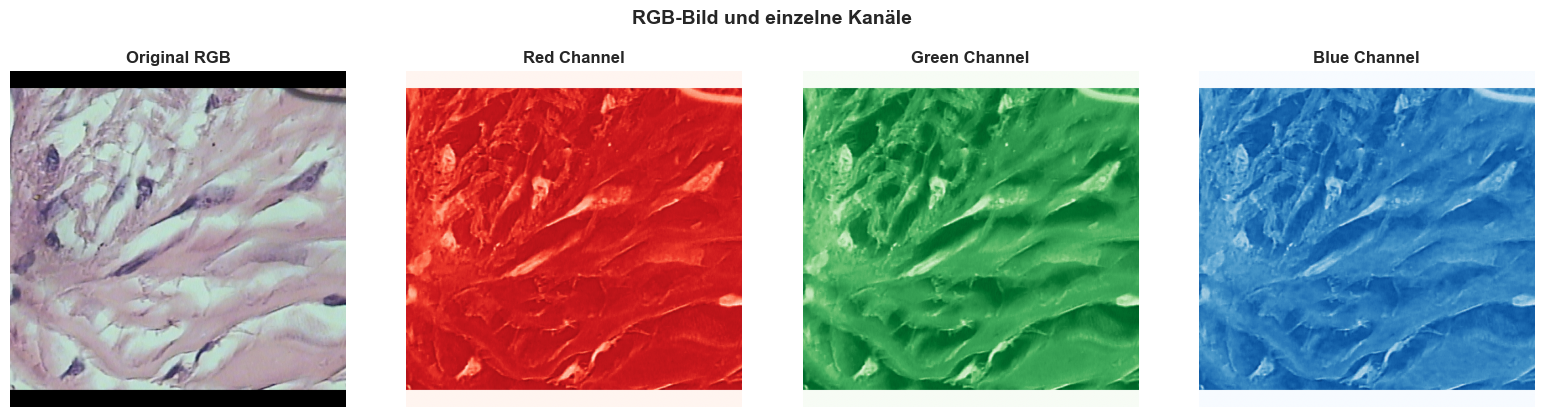

In [52]:
# Original-Bild visualisieren
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original RGB
axes[0].imshow(img_rgb)
axes[0].set_title('Original RGB', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Einzelne Kanäle
channel_names = ['Red', 'Green', 'Blue']
colors = ['Reds', 'Greens', 'Blues']

#Funktion um das Bild in jeweils Rot Blau und Grün anzuzeigen. 
for i, (name, cmap) in enumerate(zip(channel_names, colors)):
    axes[i+1].imshow(img_rgb[:, :, i], cmap=cmap)
    axes[i+1].set_title(f'{name} Channel', fontsize=12, fontweight='bold')
    axes[i+1].axis('off')

plt.suptitle('RGB-Bild und einzelne Kanäle', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_rgb_channels.png', dpi=150, bbox_inches='tight') # Die Bilder speichern für Präsentation 
plt.show()


#  RGB → HSV Konversion

**Warum konvertieren?**
- RGB: Rot + Grün + Blau gemischt → schwer zu interpretieren
- HSV: Trennt Farbinformation (H, S) von Helligkeit (V)
- **Kritisch für H&E-Färbung:** Saturation zeigt Färbungsintensität!

In [53]:
# RGB → HSV konvertieren
# scikit-image erwartet Float-Werte in Format 0-1
img_rgb_float = img_as_float(img_rgb) #img_as_float konvertiert RGB(0-255) in (0-1)
img_hsv = color.rgb2hsv(img_rgb_float)


print("HSV Array-Eigenschaften:")
print(f"  Shape: {img_hsv.shape}")
print(f"  Dtype: {img_hsv.dtype}")
print(f"\n Wertebereiche pro Kanal:")
print(f"  H (Hue):        {img_hsv[:,:,0].min():.3f} - {img_hsv[:,:,0].max():.3f}")
print(f"  S (Saturation): {img_hsv[:,:,1].min():.3f} - {img_hsv[:,:,1].max():.3f}")
print(f"  V (Value):      {img_hsv[:,:,2].min():.3f} - {img_hsv[:,:,2].max():.3f}")

HSV Array-Eigenschaften:
  Shape: (512, 512, 3)
  Dtype: float64

 Wertebereiche pro Kanal:
  H (Hue):        0.000 - 0.994
  S (Saturation): 0.000 - 0.738
  V (Value):      0.000 - 0.980


# HSV-Kanäle analysieren

**Frage:** Welcher Kanal zeigt am besten die Unterschiede zwischen Tumor und Normal?

**Hypothese:** Saturation (S) sollte hoch sein bei stark gefärbten Tumorbereichen!

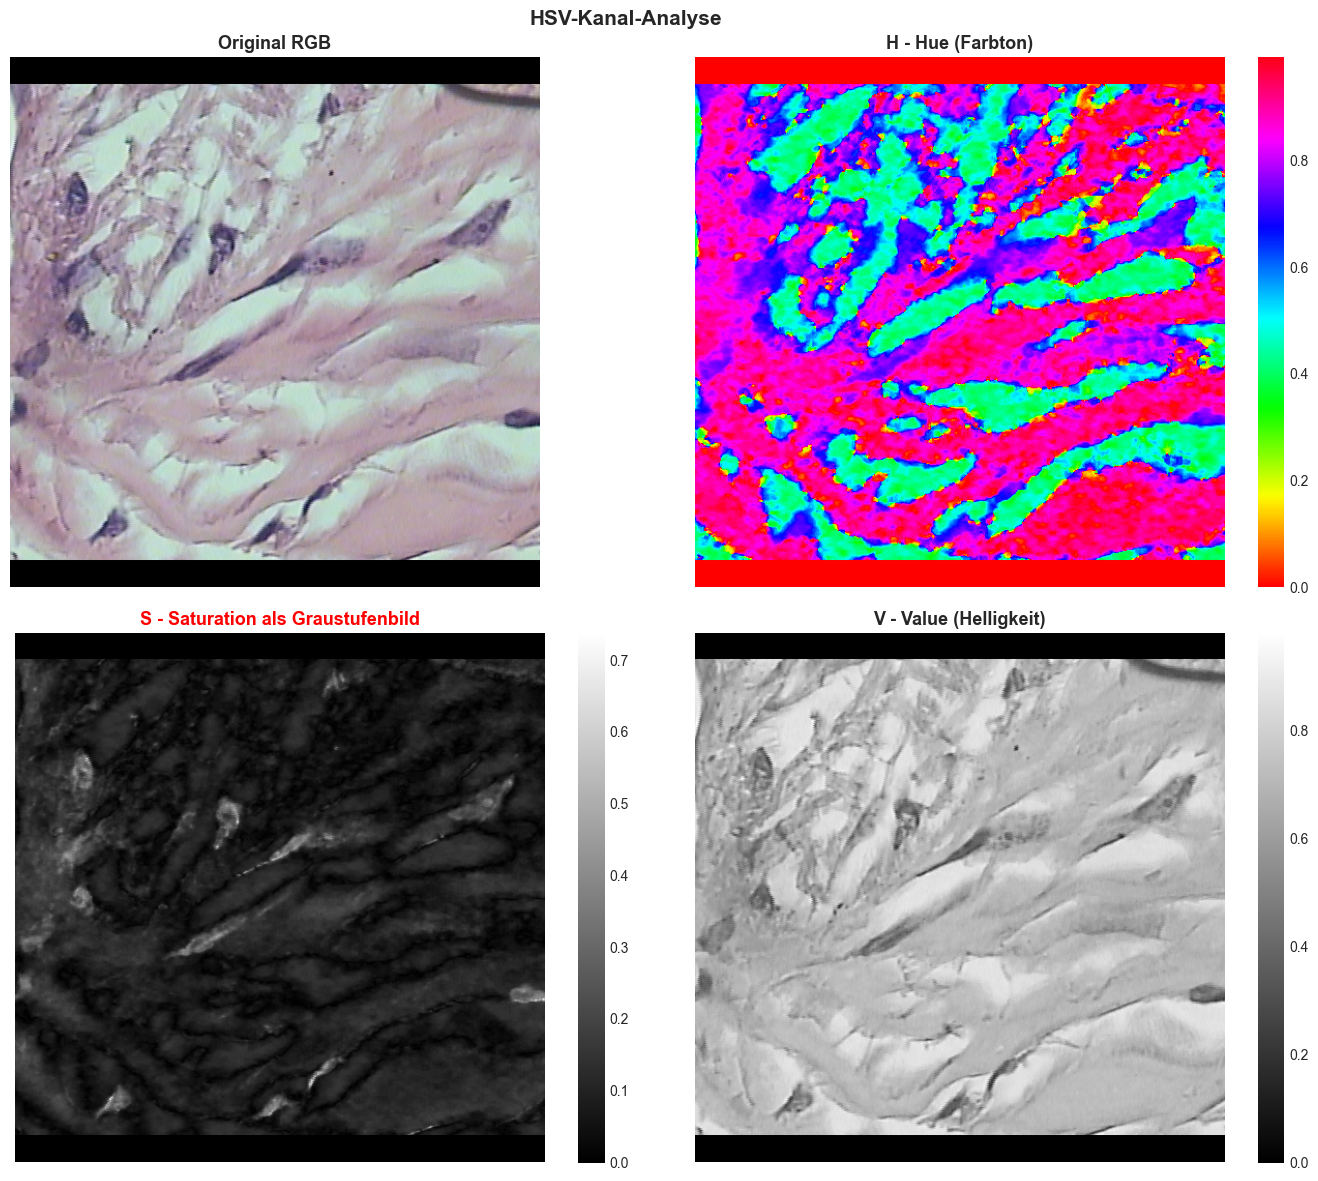


 Plot gespeichert: results/figures/02_hsv_channels.png


In [63]:
# HSV-Kanäle einzeln visualisieren
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original RGB
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title('Original RGB', fontsize=13, fontweight='bold')
axes[0, 0].axis('off')

# Hue (Farbton)
im1 = axes[0, 1].imshow(img_hsv[:,:,0], cmap='hsv')
axes[0, 1].set_title('H - Hue (Farbton)', fontsize=13, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

# Saturation (Sättigung)
im2 = axes[1, 0].imshow(img_hsv[:,:,1], cmap='gray')
axes[1, 0].set_title('S - Saturation als Graustufenbild', fontsize=13, fontweight='bold', color='red')
axes[1, 0].axis('off')
plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)

# Value (Helligkeit)
im3 = axes[1, 1].imshow(img_hsv[:,:,2], cmap='gray')
axes[1, 1].set_title('V - Value (Helligkeit)', fontsize=13, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

plt.suptitle('HSV-Kanal-Analyse', fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '02_hsv_channels.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Plot gespeichert: results/figures/02_hsv_channels.png")

# Zusätzlich zu der Beobachtung: wir merken hier deutlich dass der Hue etwa instabil ist deswegen ist es ungeeignet 

### Ergebnisse der Kanal-Analyse

### Beobachtung

Die visuelle Analyse der HSV-Kanäle zeigt, dass der Sättigungs-Kanal (S) die stark gefärbten Gewebestrukturen am deutlichsten hervorhebt.  
Der Hue-Kanal (H) erweist sich hingegen als instabil, insbesondere in schwach gefärbten oder homogenen Bildbereichen.

Eine hohe Sättigung entspricht einer intensiven Farbstoffbindung und ist somit ein Hinweis auf eine erhöhte Zelldichte, wie sie häufig in pathologischem Gewebe, insbesondere in Tumorarealen, beobachtet wird.


### Statistiken der Kanäle vergleichen

Lass uns die Verteilungen quantitativ vergleichen:

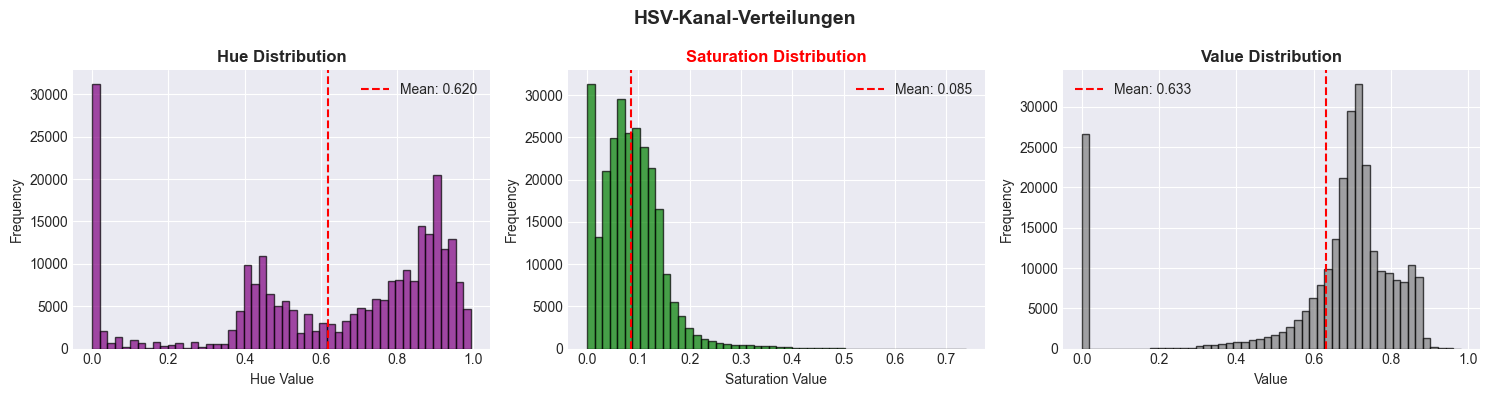


 Statistik-Zusammenfassung:
  H - Mean: 0.620, Std: 0.311
  S - Mean: 0.085, Std: 0.060 **
  V - Mean: 0.633, Std: 0.232

 Plot gespeichert: results/figures/03_hsv_histograms.png


In [55]:
# Histogramme der HSV-Kanäle
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Hue
axes[0].hist(img_hsv[:,:,0].flatten(), bins=50, color='purple', alpha=0.7, edgecolor='black') # flatten() macht daraus eine lange Liste aller Pixelwerte
axes[0].set_title('Hue Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hue Value')
axes[0].set_ylabel('Frequency')
axes[0].axvline(img_hsv[:,:,0].mean(), color='red', linestyle='--', label=f'Mean: {img_hsv[:,:,0].mean():.3f}')
axes[0].legend()

# Saturation
axes[1].hist(img_hsv[:,:,1].flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Saturation Distribution', fontsize=12, fontweight='bold', color='red')
axes[1].set_xlabel('Saturation Value')
axes[1].set_ylabel('Frequency')
axes[1].axvline(img_hsv[:,:,1].mean(), color='red', linestyle='--', label=f'Mean: {img_hsv[:,:,1].mean():.3f}')
axes[1].legend()

# Value
axes[2].hist(img_hsv[:,:,2].flatten(), bins=50, color='gray', alpha=0.7, edgecolor='black')
axes[2].set_title('Value Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].axvline(img_hsv[:,:,2].mean(), color='red', linestyle='--', label=f'Mean: {img_hsv[:,:,2].mean():.3f}')
axes[2].legend()

plt.suptitle('HSV-Kanal-Verteilungen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_hsv_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Statistik-Zusammenfassung:")
print(f"  H - Mean: {img_hsv[:,:,0].mean():.3f}, Std: {img_hsv[:,:,0].std():.3f}")
print(f"  S - Mean: {img_hsv[:,:,1].mean():.3f}, Std: {img_hsv[:,:,1].std():.3f} **")
print(f"  V - Mean: {img_hsv[:,:,2].mean():.3f}, Std: {img_hsv[:,:,2].std():.3f}")
print("\n Plot gespeichert: results/figures/03_hsv_histograms.png")

### Histogramm-Analyse der HSV-Kanäle

Die Histogramme der HSV-Kanäle quantifizieren die Pixelwertverteilungen der einzelnen Kanäle.  
Der Sättigungs-Kanal (S) zeigt eine klare Trennung zwischen Hintergrund (niedrige Sättigung) und stark gefärbtem Gewebe (hohe Sättigung).  
Der Hue-Kanal (H) ist instabil und der Value-Kanal (V) hauptsächlich von Belichtung und Scannerlicht beeinflusst.  
Mittelwert und Standardabweichung der S-Kanäle liefern erste quantitative Kennzahlen für die nachfolgende Maskierung und Texturanalyse.


# Schwellenwert-Maskierung auf Saturation

**Ziel:** Bereiche mit hoher Färbungsintensität isolieren

**Methode:** Schwellenwert (Threshold) anwenden
- Pixel mit Saturation > Threshold → stark gefärbt (1)
- Pixel mit Saturation ≤ Threshold → schwach gefärbt (0)

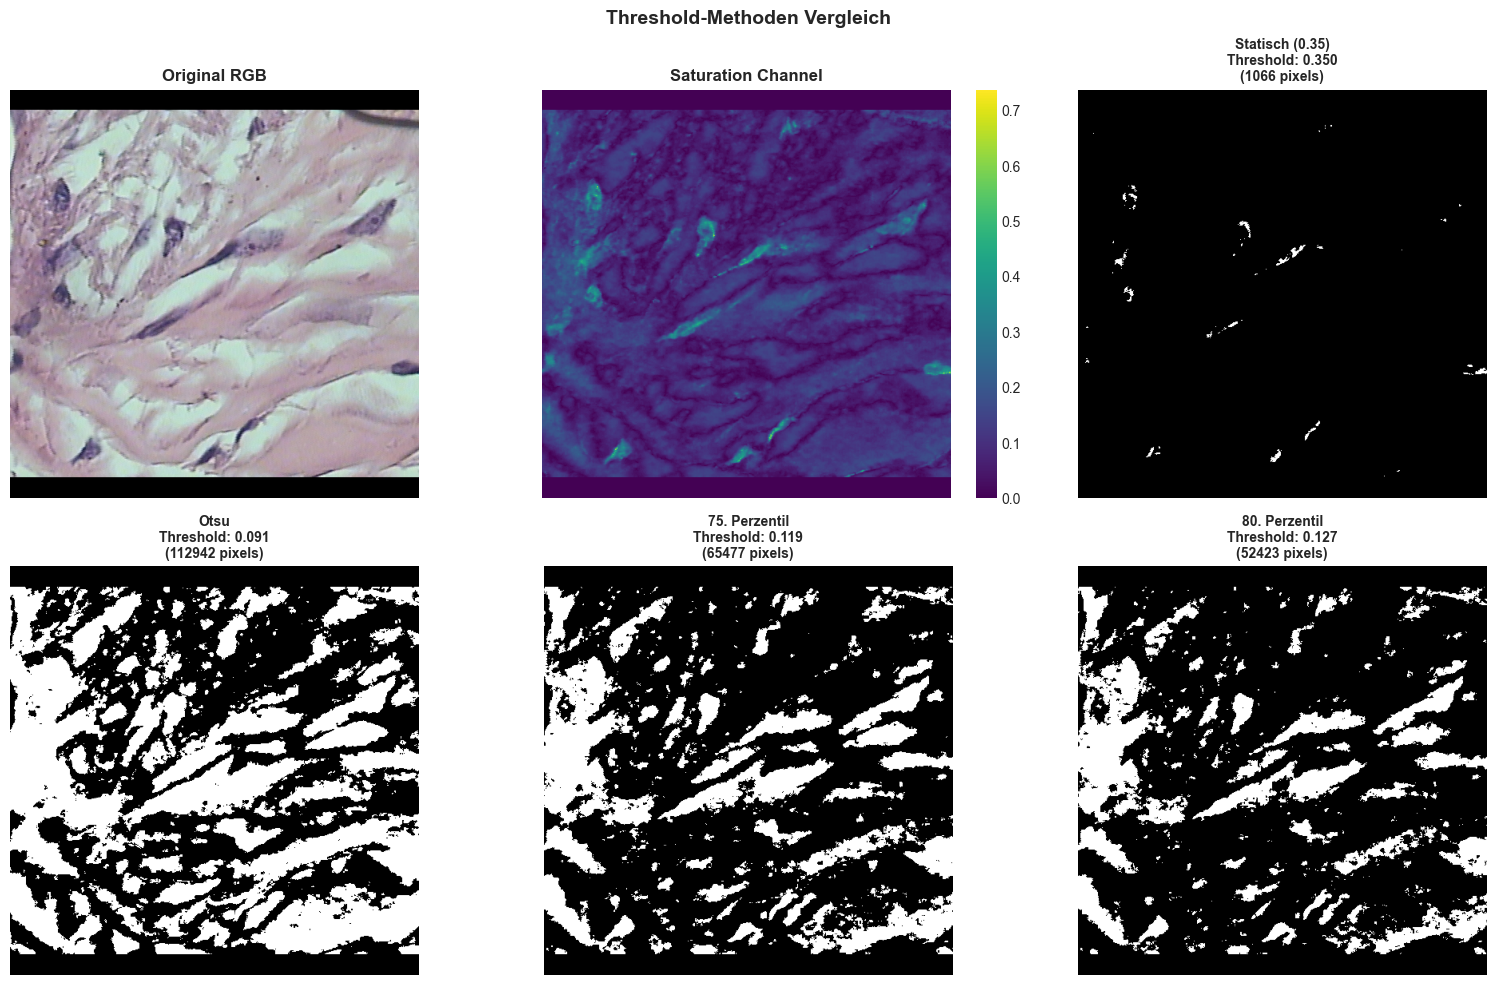


ERGEBNISSE:
Statisch (0.35)     : Threshold=0.350, Pixels=1066 (0.4%)
Otsu                : Threshold=0.091, Pixels=112942 (43.1%)
75. Perzentil       : Threshold=0.119, Pixels=65477 (25.0%)
80. Perzentil       : Threshold=0.127, Pixels=52423 (20.0%)


In [62]:
saturation = img_hsv[:,:,1]

# Verschiedene Threshold-Methoden vergleichen
thresholds = {
    'Statisch (0.35)': 0.35,
    'Otsu': filters.threshold_otsu(saturation),
    '75. Perzentil': np.percentile(saturation, 75),
    '80. Perzentil': np.percentile(saturation, 80)
}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Original
axes[0].imshow(img_rgb)
axes[0].set_title('Original RGB', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Saturation
im = axes[1].imshow(saturation, cmap='viridis')
axes[1].set_title('Saturation Channel', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Verschiedene Thresholds
for idx, (method, thresh) in enumerate(thresholds.items()):
    mask = saturation > thresh
    axes[idx+2].imshow(mask, cmap='gray')
    axes[idx+2].set_title(
        f'{method}\nThreshold: {thresh:.3f}\n({mask.sum()} pixels)',
        fontsize=10,
        fontweight='bold'
    )
    axes[idx+2].axis('off')

plt.suptitle('Threshold-Methoden Vergleich', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nERGEBNISSE:")
for method, thresh in thresholds.items():
    mask = saturation > thresh
    percentage = (mask.sum() / mask.size) * 100
    print(f"{method:20s}: Threshold={thresh:.3f}, Pixels={mask.sum()} ({percentage:.1f}%)")


# Fazit 
Zur Segmentierung stark gefärbter Gewebestrukturen wurden verschiedene Schwellenwert-Methoden verglichen, darunter ein fixer Threshold, das Otsu-Verfahren sowie perzentilbasierte Ansätze.
Während fixe Thresholds zu einer starken Übersegmentierung führten und Otsu nach vielen Testen etwa unstabill ist, erwies sich ein perzentilbasierter Threshold als robuster.
Das 75. Perzentil wurde als optimaler Kompromiss zwischen Sensitivität und Spezifität gewählt und für alle weiteren Analysen verwendet.

##  Maske auf Original-Bild anwenden

Zeigen wir, welche Bereiche durch unsere Maske isoliert werden:

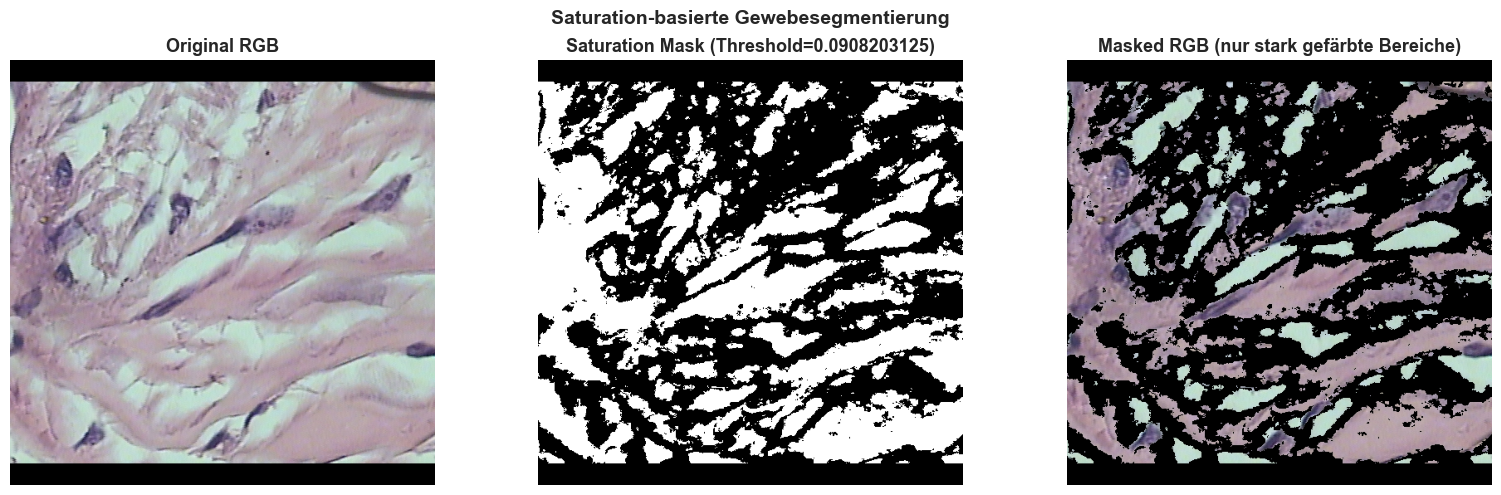


Maske erstellt mit Threshold = 0.0908203125
 112942 Pixel identifiziert als stark gefärbt (43.1%)
 Plot gespeichert: results/figures/05_masked_tissue.png


In [57]:
# Optimalen Threshold wählen
percentile = 75  # oberste 25 %
threshold = np.percentile(saturation, percentile)

threshold = filters.threshold_otsu(saturation)

mask = saturation > threshold

# Maske auf RGB anwenden
masked_img = img_rgb.copy()
masked_img[~mask] = 0  # Bereiche außerhalb der Maske = schwarz

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(img_rgb)
axes[0].set_title('Original RGB', fontsize=13, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title(f'Saturation Mask (Threshold={threshold})', fontsize=13, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(masked_img)
axes[2].set_title('Masked RGB (nur stark gefärbte Bereiche)', fontsize=13, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Saturation-basierte Gewebesegmentierung', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '05_masked_tissue.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMaske erstellt mit Threshold = {threshold}")
print(f" {mask.sum()} Pixel identifiziert als stark gefärbt ({(mask.sum()/mask.size)*100:.1f}%)")
print(" Plot gespeichert: results/figures/05_masked_tissue.png")

##  Zusammenfassung 

### Was gemacht wurde
1. Daten geladen und exploriert (100 Bilder, 50/50 Tumor/Normal)
2. Bilder als Numpy Arrays verstanden (Height × Width × Channels)
3. RGB → HSV Konversion durchgeführt
4. **Saturation-Kanal als optimal identifiziert**
5. Schwellenwert-Maskierung implementiert

### Erkenntnisse:
- **Saturation trennt gut** zwischen stark/schwach gefärbten Bereichen
- Threshold mit perzentile Methode isoliert relevante Gewebestrukturen
- Maskierung funktioniert zur Fokussierung auf pathologische Bereiche

** Alle Visualisierungen gespeichert in:** `results/figures/`

## Alle Sample-Bilder verarbeiten

Jetzt auf alle verfügbaren Bilder anwenden, um zu sehen ob unser Ansatz robust ist:

In [64]:
# Funktion zum Verarbeiten eines Bildes
def process_image_to_hsv(img_path, percentile=75):
    """
    Lädt ein Bild, konvertiert zu HSV, extrahiert Saturation-Maske.
    
    Parameters:
    -----------
    img_path : str
        Pfad zum Bild
    percentile : int
        Perzentil für adaptiven Threshold (default: 75)
        75 = oberste 25% der Saturation-Werte
        80 = oberste 20% der Saturation-Werte
    
    Returns:
    --------
    dict : Dictionary mit RGB, HSV, Saturation, Maske, Threshold
    """
    # Bild laden
    img_rgb = io.imread(img_path)
    
    # RGB → HSV
    img_rgb_float = img_as_float(img_rgb)
    img_hsv = color.rgb2hsv(img_rgb_float)
    
    # Saturation extrahieren
    saturation = img_hsv[:,:,1]
    
    # Adaptiver Threshold basierend auf Perzentil
    threshold = np.percentile(saturation, percentile)

    # Maske erstellen
    mask = saturation > threshold


    return {
        'rgb': img_rgb,
        'hsv': img_hsv,
        'saturation': saturation,
        'mask': mask,
        'threshold': threshold,
        'mask_percentage': (mask.sum() / mask.size) * 100
    }

print("done...")

done...


In [65]:
# Alle Sample-Bilder verarbeiten
results = []

print("Verarbeite alle Bilder mit adaptivem Threshold (75. Perzentil)...\n")
for img_path in tqdm(available_images[:100]): 
    img_name = Path(img_path).name
    processed = process_image_to_hsv(img_path, percentile=75)  # Perzentil angeben
    
    results.append({
        'image_name': img_name,
        'threshold': processed['threshold'],  # NEU: berechneter Threshold
        'mask_percentage': processed['mask_percentage'],
        'saturation_mean': processed['saturation'].mean(),
        'saturation_std': processed['saturation'].std()
    })

# Als DataFrame
results_df = pd.DataFrame(results)
print("\nVerarbeitung abgeschlossen!\n")

results_df

Verarbeite alle Bilder mit adaptivem Threshold (75. Perzentil)...



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Verarbeitung abgeschlossen!



image_name  threshold  mask_percentage  saturation_mean  \
0   texture_patch_0079.png   0.390000        24.994659         0.274540   
1   texture_patch_0051.png   0.415301        24.987793         0.235006   
2   texture_patch_0045.png   0.073913        24.942017         0.060229   
3   texture_patch_0092.png   0.547619        24.969482         0.378921   
4   texture_patch_0086.png   0.321244        24.989319         0.244916   
..                     ...        ...              ...              ...   
95  texture_patch_0049.png   0.658291        24.969482         0.515839   
96  texture_patch_0100.png   0.350000        24.907303         0.195388   
97  texture_patch_0048.png   0.118644        24.977493         0.084931   
98  texture_patch_0060.png   0.428571        24.982071         0.267203   
99  texture_patch_0074.png   0.302857        24.930573         0.215872   

    saturation_std  
0         0.145510  
1         0.178459  
2         0.056424  
3         0.210454  
4         0.117349  
..             ...  
95        0.212801  
96        0.152795  
97        0.059756  
98        0.171076  
99        0.114436  

[100 rows x 5 columns]

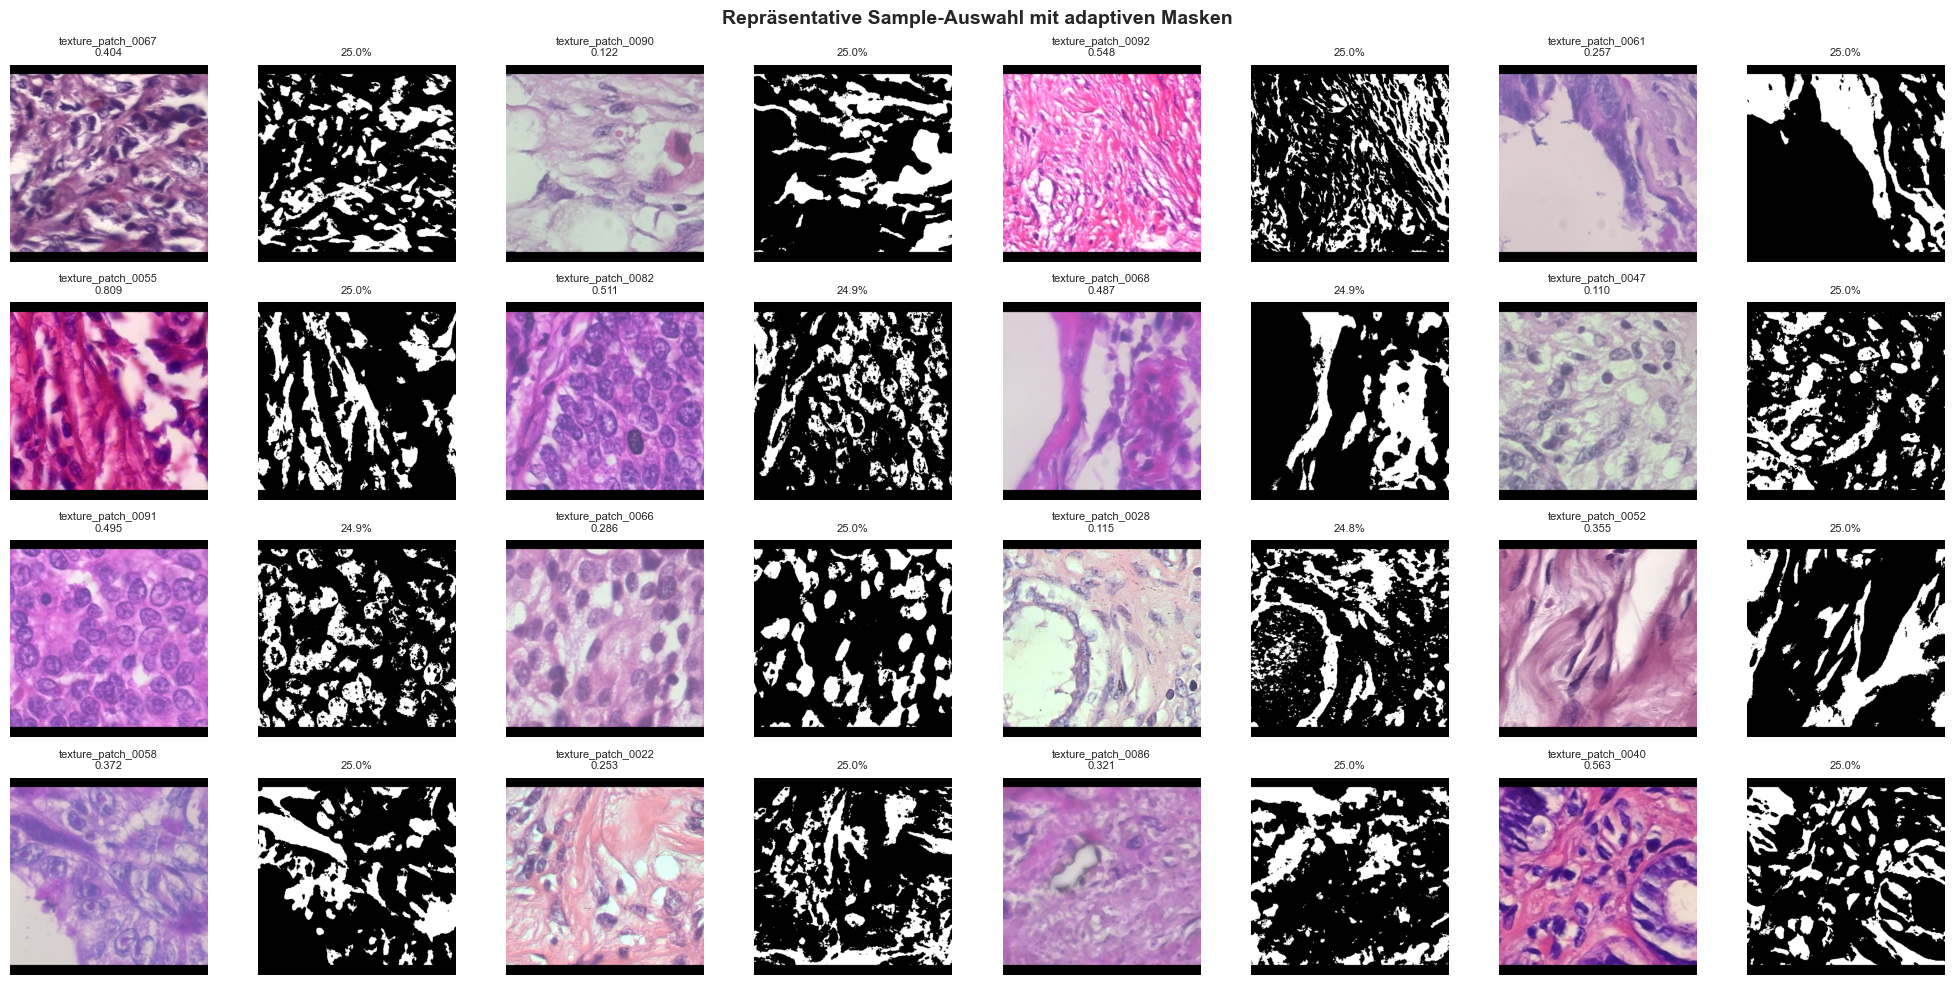

In [77]:
# Stratifizierte Auswahl: 8 Tumor + 8 Normal
n_per_class = 8

import random
random.seed(42)
selected_images = random.sample(available_images, min(16, len(available_images)))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()

for i, img_path in enumerate(selected_images):
    processed = process_image_to_hsv(img_path, percentile=75)
    
    # Original
    axes[i*2].imshow(processed['rgb'])
    axes[i*2].set_title(
        f"{Path(img_path).stem}\n{processed['threshold']:.3f}", 
        fontsize=8
    )
    axes[i*2].axis('off')
    
    # Maske
    axes[i*2+1].imshow(processed['mask'], cmap='gray')
    axes[i*2+1].set_title(f"{processed['mask_percentage']:.1f}%", fontsize=8)
    axes[i*2+1].axis('off')

# Rest ausblenden
for j in range(len(selected_images)*2, len(axes)):
    axes[j].axis('off')

plt.suptitle('Repräsentative Sample-Auswahl mit adaptiven Masken', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '06_all_samples_masked.png', dpi=150, bbox_inches='tight')
plt.show()